In [ ]:
import tensorflow as tf
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import sklearn.metrics as sk_metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
import tempfile
import statsmodels.api as sm
import os
from tensorflow import keras
import statsmodels.formula.api as smf

from tensorflow.keras import layers
from sklearn.feature_selection import SelectKBest
from sklearn import metrics
import pymssql
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from tqdm import tqdm
import numpy as np
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score
from xgboost import plot_importance


# Preset matplotlib figure sizes.
matplotlib.rcParams['figure.figsize'] = [9, 6]

print(tf.__version__)
# To make the results reproducible, set the random seed value.
tf.random.set_seed(22)

In [ ]:
conn = pymssql.connect(server='localhost', user='sa', password='Passw0rd!', database='Loans_2023_01_27')
cursor = conn.cursor()

def get_column_index(cursor, column_name):
    for index, col in enumerate(cursor.description):
        if col[0] == column_name:
            return index

additional_data_headers = ["RentMortgagePayment" ,"TotalIncome" ,"RentMortgage" ,"CarPayment" ,"Expenses" ,"AvailableIncome" ,"Miles"]
additional_data_sql = "VIN,"
for i, header in enumerate(additional_data_headers):
    additional_data_sql += header
    if i!=len(additional_data_headers)-1:
        additional_data_sql+=','

headers = []
rows = []

# Underwriting Data
cursor.execute("SELECT * FROM dbo.UnderwritingData")

for entity in cursor.description:
    headers.append(entity[0])

vin_index = get_column_index(cursor, "VIN")

res = cursor.fetchone()
while res:
    row = [element for element in res]
    if row[vin_index] is not None:
        row[vin_index] = row[vin_index]
        rows.append(row)
    res = cursor.fetchone()

df = pd.DataFrame(rows, columns=headers)


#Additional Data
cursor.execute("Select {vCols} FROM dbo.VerificationsDec".format(vCols = additional_data_sql))

addl_data_rows = []
res = cursor.fetchone()

while res:
    row = [element for element in res]
    row[0] = row[0].strip()
    addl_data_rows.append(row)
    res = cursor.fetchone()

print("Assigning Additional Entities")
for data in tqdm(addl_data_rows):
    df.loc[df['VIN']==data[0].strip(), additional_data_headers] = data[1:]

#Results from RawAlgorithmData
cursor.execute("SELECT Vin6,ProcStatsCd,Delq FROM dbo.RawAlgorithmData")
res = cursor.fetchone()
loan_results = dict()
delq_results = dict()
while res:
    vin6 = res[0].strip()
    if len(vin6)==17:
        # print("adding")
        loan_results[vin6] = res[1].strip()
        delq_results[vin6] = res[2]
    res = cursor.fetchone()

default_result = ["NA" for i in range(len(df))]
default_delq = ["NA" for i in range(len(df))]
df['Result'] = default_result
df['Delq'] = default_delq

df = df[df['OpeningBalance']!=0]

print("Assigning Results")
for vin6, res in tqdm(loan_results.items()):
    # print(vin6)
    df.loc[df['VIN'] == vin6, ['Result', 'Delq']] = [res, delq_results[vin6]]
    # print(df.loc[df['VIN'] == vin6])

df = df[["RentMortgagePayment" ,"TotalIncome" ,"CarPayment" ,"Expenses" ,"AvailableIncome" ,"Miles", "OpeningBalance","Salary","Term","VehicleYear","CreaditScore","LTV","DTI","TradelinesTotal","TradelinesBalance","Reposessions","Bankrupcies","Chageoff","Mortgage","NinetyDaysDelinquent","InquiresTotal","OpenTotal","ClosedTotalTermsNotPaid","LatePaymentHistory001230","LatePaymentHistory001260","LatePaymentHistory001290Plus","PaidAccounts","InquiriesLast6Months","OpenTotalInBadStatus","CurrentPaymentsMade","RentMortgage","CashDown","HomeOwner", "Delq", "Result"]]

print(df)
dfCLOnly = df.copy(deep=True)
dfCLOnly = dfCLOnly[(dfCLOnly['Result']=='CL')]
dfCLOnly['Result'].replace(to_replace=['CO', 'CL'], value=[0,1], inplace=True)
dfCLOnly['HomeOwner'].replace(to_replace=['N', 'Y'], value=[0,1], inplace=True)
dfCLOnly['DelqPct'] = dfCLOnly.apply(lambda row : (100*row['Delq'])/row['OpeningBalance'],axis=1)
dfCLOnly.fillna(dfCLOnly.mean(), inplace=True)


df = df[(df['Result']=='CO') | (df['Result']=='CL')]
df['Result'].replace(to_replace=['CO', 'CL'], value=[0,1], inplace=True)
df['HomeOwner'].replace(to_replace=['N', 'Y'], value=[0,1], inplace=True)
df['DelqPct'] = df.apply(lambda row : (100*row['Delq'])/row['OpeningBalance'],axis=1)
df.fillna(df.mean(), inplace=True)

df = df[["RentMortgagePayment" ,"TotalIncome" ,"CarPayment" ,"Expenses" ,"AvailableIncome" ,"Miles", "OpeningBalance","Salary","Term","VehicleYear","CreaditScore","LTV","DTI","TradelinesTotal","TradelinesBalance","Reposessions","Bankrupcies","Chageoff","Mortgage","NinetyDaysDelinquent","InquiresTotal","OpenTotal","ClosedTotalTermsNotPaid","LatePaymentHistory001230","LatePaymentHistory001260","LatePaymentHistory001290Plus","PaidAccounts","InquiriesLast6Months","OpenTotalInBadStatus","CurrentPaymentsMade","RentMortgage","CashDown","HomeOwner", "DelqPct"]]

dfCLOnly = dfCLOnly[["RentMortgagePayment" ,"TotalIncome" ,"CarPayment" ,"Expenses" ,"AvailableIncome" ,"Miles", "OpeningBalance","Salary","Term","VehicleYear","CreaditScore","LTV","DTI","TradelinesTotal","TradelinesBalance","Reposessions","Bankrupcies","Chageoff","Mortgage","NinetyDaysDelinquent","InquiresTotal","OpenTotal","ClosedTotalTermsNotPaid","LatePaymentHistory001230","LatePaymentHistory001260","LatePaymentHistory001290Plus","PaidAccounts","InquiriesLast6Months","OpenTotalInBadStatus","CurrentPaymentsMade","RentMortgage","CashDown","HomeOwner", "DelqPct"]]
print(df)


In [ ]:
print(df)

In [ ]:
def remove_outliers(df,columns,n_std):
    for col in columns:
        print('Working on column: {}'.format(col))

        mean = df[col].mean()
        sd = df[col].std()

        df = df[(df[col] <= mean+(n_std*sd))]

    return df

df2 = remove_outliers(df, df.columns, 3)

In [ ]:
# # fig, axes = plt.subplots(ncols=3)
# # for i, yvar in enumerate(df.columns):
# #     axes[i].scatter(df['Result'],df[yvar])
#
# df3 =  remove_outliers(df2, df2.columns, 3)
#
# pp = sns.pairplot(data=df2,
#                   y_vars=["DelqPct"],
#                   x_vars=df.columns)
#
# pp

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    df2.iloc[:,:-1], df2.iloc[:,-1:], test_size=0.2, random_state=42)


resdict= dict()
rdict = dict()

num_features = [i for i in range(1, len(df.columns)-2)]

# for nf in tqdm(num_features):
#     linReg = LinearRegression()
#     rfe = RFE(estimator = linReg, n_features_to_select = nf)
#     rfe.fit(x_train, y_train.values.ravel())
#
#
#     train_pred = rfe.predict(x_train)
#     test_pred = rfe.predict(x_test)
#
#     resdict[nf] = np.sqrt(metrics.mean_squared_error(y_test, test_pred))
#     rdict[nf] = metrics.r2_score(y_test, test_pred)

print(resdict)
print(rdict)

linReg = LinearRegression()
rfe = RFE(estimator = linReg, n_features_to_select = 59)
rfe.fit(x_train, y_train.values.ravel())


train_pred = rfe.predict(x_train)
test_pred = rfe.predict(x_test)

print("LinearRegression")
print("R^2 : ", metrics.r2_score(y_test, test_pred))
print("MAE :", metrics.mean_absolute_error(y_test,test_pred))
print("RMSE: ",np.sqrt(metrics.mean_squared_error(y_test, test_pred)))


In [ ]:
# print(y_train)

# x_train = sm.add_constant(x_train)
for p1 in df.columns:
    for p2 in df.columns:
        if p1==p2:
            continue
        model = smf.ols(formula='DelqPct ~ ' + p1 + '*'+p2, data =df).fit()
        params = model.params
        print(p1 + " and "+p2)
        print("Coefficients: ")
        print(params)
        print()
        print("P Values: ")
        print(model.pvalues)
        print()
        print()


In [ ]:
# x_test = sm.add_constant(x_test)
#
# print(est.predict(x_train[:5]))
# print(y_train[:5])


### TensorFlow

In [ ]:
def remove_outliers(df,columns,n_std):
    for col in columns:
        print('Working on column: {}'.format(col))

        mean = df[col].mean()
        sd = df[col].std()

        df = df[(df[col] <= mean+(n_std*sd))]

    return df

df = remove_outliers(df, df.columns, 3)

print(df)

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(
    df.iloc[:,:-1], df.iloc[:,-1:], test_size=0.2, random_state=42)


normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())


In [ ]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [ ]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

In [ ]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [DelqPct]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

#Overfitting is when the model fits the training data too closely, and the loss keeps decreasing while the val_loss is stale, or increases.
#which looks to be exactly what is happening here

In [ ]:
test_results = dict()
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)
pd.DataFrame(test_results, index=['Mean absolute error [DelqPCT]']).T

In [ ]:
test_predictions = dnn_model.predict(test_features).flatten()

print(test_predictions[:5])
print(test_labels[:5])

error = test_predictions.reshape(test_predictions.shape[0],1) - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [DelqPct]')
_ = plt.ylabel('Count')

### XGBoost

In [ ]:
xgdata = df.copy(deep=True)
for x in tqdm(range(1)):
    x_train, x_test, y_train, y_test = train_test_split(xgdata.iloc[:,:-1], xgdata.iloc[:,-1:], test_size=0.2)

    train = xgb.DMatrix(x_train, label=y_train)
    test = xgb.DMatrix(x_test, label=y_test)

    param = {
        'eta': 0.01,
        'objective': 'reg:squarederror',
    }
    epochs = 500

    model = xgb.train(param, train, epochs)

    predictions = model.predict(test)

    y = []

    for z in predictions:
        y.append(np.argmax(z))

    acc = round(metrics.mean_squared_error(y_test, y, squared=False), 3)
    model.save_model('Models/Delq/XGBoost_{}%_Scorelate.json'.format(acc))

[6.881691  4.2824516 5.447965  3.577157  3.4948053]
        DelqPct
1466  13.190324
9447   5.169959
775    8.453127
7444   0.000000
1293   0.000000


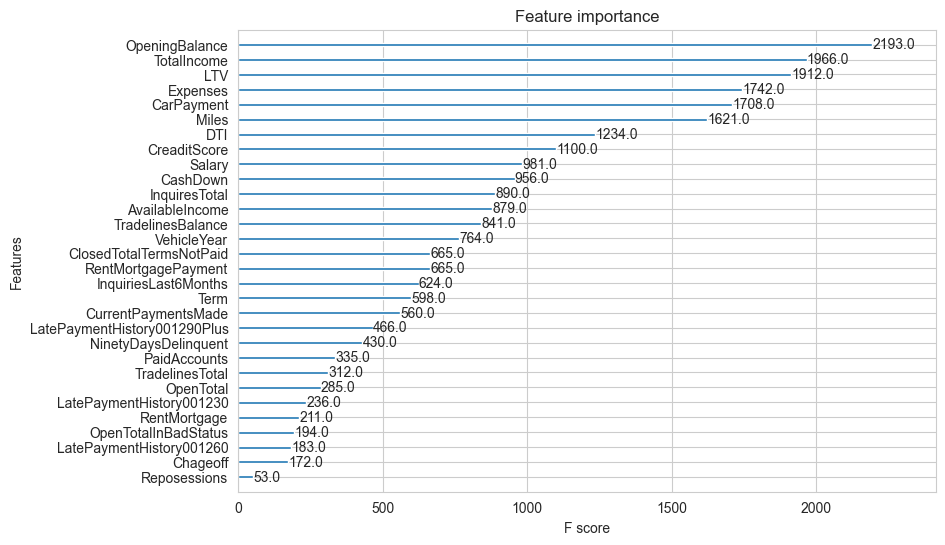

Paid and Pred Paid:  5
Paid and Pred CO:  649
CO and Pred Paid:  0
CO and Pred CO:  671


In [167]:
xgb_ml = xgb.Booster()

xgb_ml.load_model('Models/Delq/XGBoost_6.966%_Scorelate.json')
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df.iloc[:,-1:], test_size=0.2)
print(xgb_ml.predict(xgb.DMatrix(x_test[:5])))
print(y_test[:5])

# plot feature importance
plot_importance(xgb_ml)
plt.show()

res = xgb_ml.predict(xgb.DMatrix(x_test))
preds = []
actual = []
for pred in res:
    if(pred<0.1):
        preds.append("Paid")
    else:
        preds.append("CO")

for result in y_test["DelqPct"]:
    if result == 0.0:
        actual.append("Paid")
    else:
        actual.append("CO")

paidandpredpaid = 0
paidandpredco = 0
coandpredpaid = 0
coandpredco = 0

for i in range(len(preds)):
    if preds[i]=="Paid" and actual[i]=="Paid":
        paidandpredpaid+=1
    elif preds[i]=="CO" and actual[i]=="Paid":
        paidandpredco+=1
    elif preds[i]=="Paid" and actual[i]=="CO":
        coandpredpaid+=1
    elif preds[i]=="CO" and actual[i]=="CO":
        coandpredco+=1

print("Paid and Pred Paid: ", paidandpredpaid)
print("Paid and Pred CO: ", paidandpredco)
print("CO and Pred Paid: ", coandpredpaid)
print("CO and Pred CO: ", coandpredco)